# Regression models: week 1

Regression analysis is mainly used to study dependence. There are three major research task we migh come across:

- descriptive tasks 
- predictive tasks
- causal tasks 

### Conditional means: The main interest of regression analysis

As an example of a descriptive question, let's consider: "How does marital status and race affect wage?" In this case, wage is a random variable generated from a particular distribution. When we ask "How does being married affect my wage?", we are essentially interested in the conditional distribution of wages given marital status. Similarly, asking "How does an individual's race affect their wage?" is also seeking to understand the conditional distribution of wages based on race.

### Dependencies 

For our analysis, we will be using the `wage2` dataset from the `{wooldridge}` R package. To install this package, simply run the following command for your R environment.

```R
install.packages("wooldridge")
```

We are going to use `{dplyr}` package for data manipulation and `{ggplot2}` for proper visualization.

```R
install.packages(
c("dplyr", "ggplot2")
)
```

### Data 

In [1]:
library(dplyr)
library(ggplot2)
data <- wooldridge::wage2


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




We'll now use a *scatterplot* for an initial data visualization. First scratterplot is visualized by the number of observation (index). 

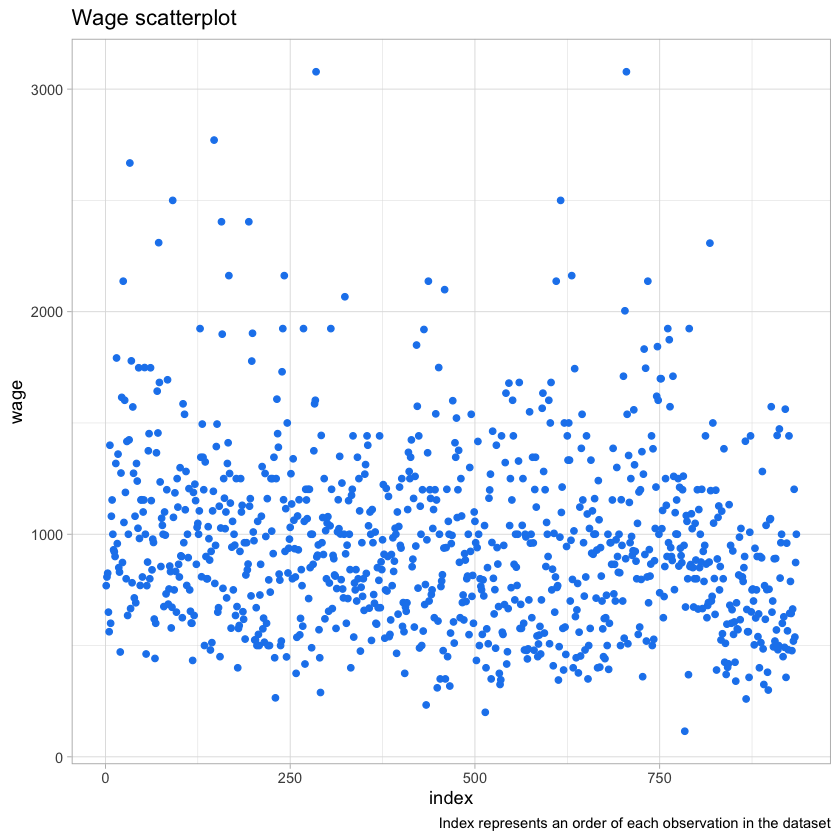

In [2]:
data %>% 
mutate(index = row_number()) %>%
ggplot(aes(y = wage, x = index))+
geom_point(colour = 'dodgerblue2')+
labs(title = "Wage scatterplot", caption = "Index represents an order of each observation in the dataset")+
theme_light()

Notice I used a special operator called "pipe operator" `%>%`. In Rstudio, there is a key shortcut `CMD+Shift+M`. 

This operator passes the result of a function as an argument into the subsequent function.

Since we are interested in an effect of race on hourly wage, we might want to visualize our datsa in wage-race space given by variables *wage* and categorical variable *black*.

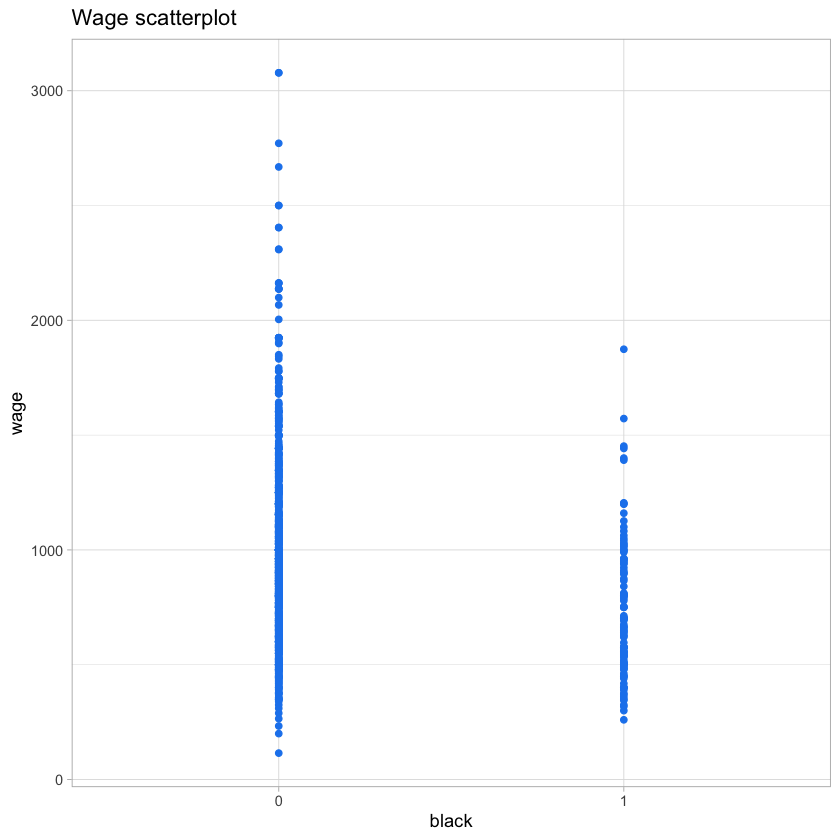

In [3]:
data %>% 
ggplot(aes(y = wage, x = factor(black))) + # notice I used factor to ensure that variable black is not treated as double.
geom_point(colour = 'dodgerblue2') +
labs(title = "Wage scatterplot",
     x = "black") +
theme_light()

As mentioned earlier, wage is a random variable that follows a particular distribution. To gain insight into the distribution of wages in our dataset, we can create a simple histogram with a density plot overlay. It's important to note that in order to properly scale the y-axis for the density plot, we need to include `..density..` in the y argument of the histogram aesthetics function, `aes()`. This ensures that the density plot is properly scaled with respect to the histogram.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



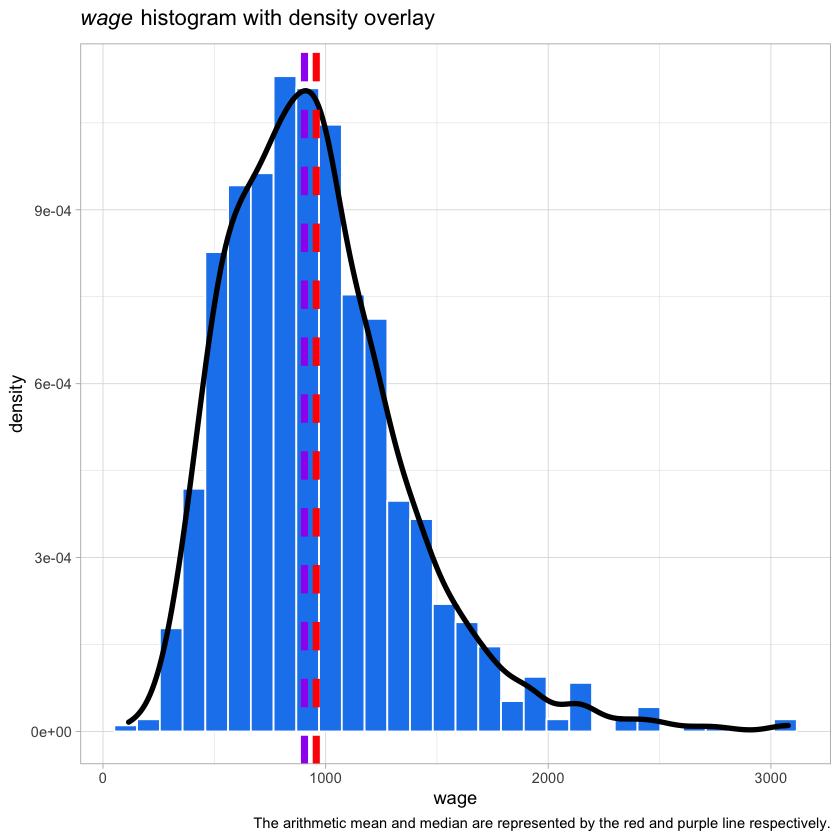

In [4]:
data %>% 
ggplot(aes(x = wage)) +
geom_histogram(aes(y=..density..), fill = "dodgerblue2", colour = "white") +
geom_density(lwd=1.5) +
geom_vline(aes(xintercept = mean(wage)), colour = "red", lty = "dashed", lwd = 2) +
geom_vline(aes(xintercept = median(wage)), colour = "purple", lty = "dashed", lwd = 2) +
ggtitle(expression(
        paste(italic("wage"), " histogram with density overlay")))+
labs(caption = "The arithmetic mean and median are represented by the red and purple line respectively.") +
theme_light()

The mean is not a robust measure of the central tendency of wages in this case, as the mean wage is greater than the median wage. This discrepancy is often observed in wage distributions, which tend to be skewed and have a long right tail. Interpreting the mean as the typical observed wage would not be correct in this scenario. To address this issue, a common approach is to apply a logarithmic transformation to the wage data. This transformation can help to reduce the skewness of the distribution and provide a more accurate representation of the typical wage.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



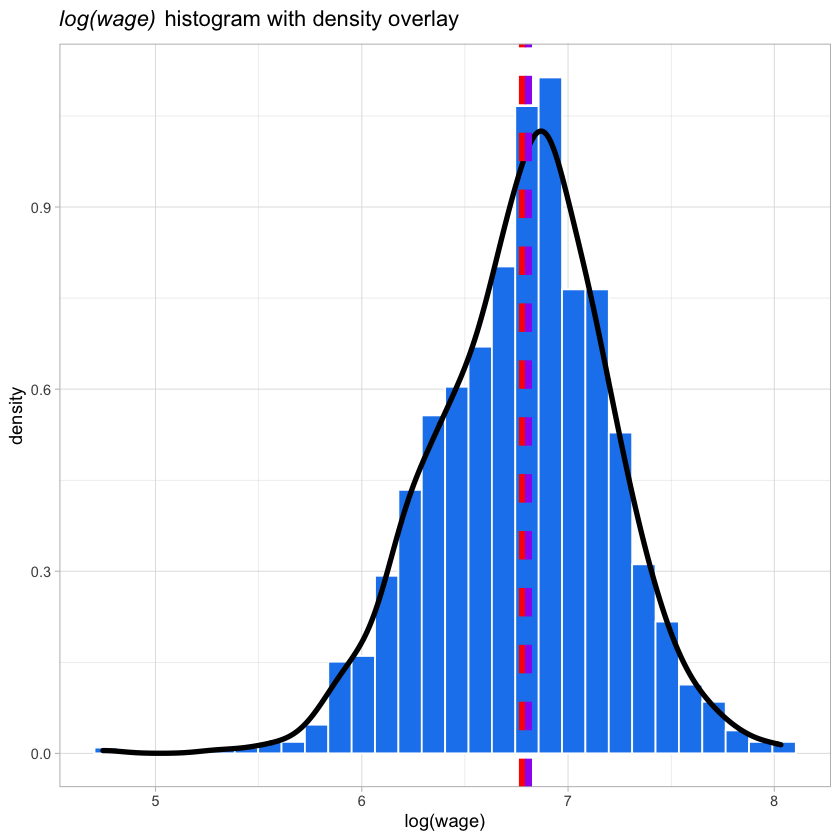

In [5]:
data %>% 
mutate(black = as.factor(black)) %>%
ggplot(aes(x = log(wage)))+
geom_histogram(aes(y=..density..), fill = "dodgerblue2", colour = "white")+
geom_density(lwd=1.5)+
geom_vline(aes(xintercept = mean(log(wage))), colour = "red", lty = "dashed", lwd = 2)+
geom_vline(aes(xintercept = median(log(wage))), colour = "purple", lty = "dashed", lwd = 2)+
ggtitle(
    expression(
        paste(italic("log(wage)"), " histogram with density overlay")))+
theme_light()

Now lets see how the distributions differ across race in our sample:

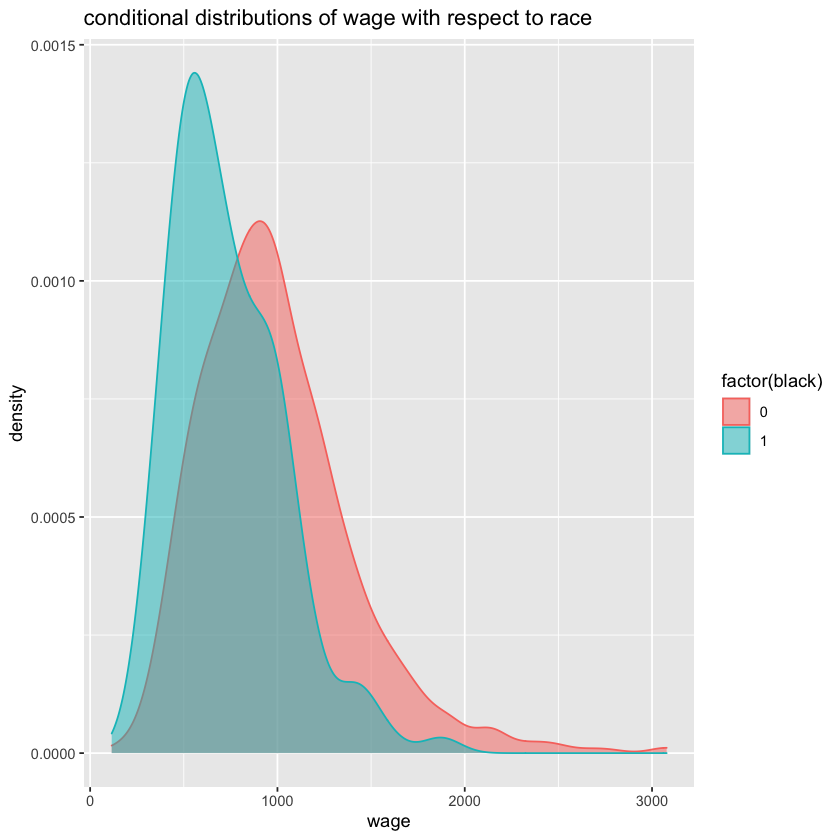

In [6]:

data %>%
ggplot(aes(x = wage, colour = factor(black), fill = factor(black)))+
geom_density(alpha = 0.5) + 
labs(title = "conditional distributions of wage with respect to race")

<div class="alert alert-block alert-warning">
Visualizing conditional expectation is merely for illustrative purposes. This only describes what is in our data!    
<br>
<br>
<i>It is not a model, let alone an analysis of causation!</i>
<br> 
</div>

To simplify our analysis and for the purpose of modelling, we will focus on the central tendency of the conditional distributions. Specifically, we will use conditional means as estimates for the conditional expectations in our analysis.

conditional expectations of random variable $Y$ given $X$ is denoted as $\mathbb{E}[ Y \vert X ]$.

We now may summarize our data for us to see the conditional means of log(wage) subject to race as follows:

In [7]:
data %>%
group_by(black) %>% 
summarize(mean_wage = mean(wage))

black,mean_wage
<int>,<dbl>
0,990.6479
1,735.8417


Conditional mean is one of the measures of conditional distributions. Focusing on this measure of central tendency reduces complexity of the analysis from analyzing these distributions as whole to focusing just on the conditional expectations

## Correlation: Measuring the strength and direction of a linear relationship between two variables

For correlation analysis we'll use nutrition facts data from Starbucks food menu. For details and further datasets check out this [link](https://www.kaggle.com/datasets/starbucks/starbucks-menu?resource=download&select=starbucks-menu-nutrition-food.csv).

<div class="alert alert-block alert-info">
<b>Tip:</b> CSV's may have different UNICODE encodings. This one is encoded in UTF-16. Make sure to take into account the file encoding in `read_csv()` function.
</div> 

In [8]:
data <- readr::read_csv("data/starbucks-menu-nutrition-food.csv",
                        locale = readr::locale(encoding = "UTF-16"))

New names:
• `` -> `...1`
Rows: 113 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (5): Calories, Fat (g), Carb. (g), Fiber (g), Protein (g)

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
data <- data %>%
  rename(Product = ...1)

data %>%
    head()

Product,Calories,Fat (g),Carb. (g),Fiber (g),Protein (g)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Chonga Bagel,300,5,50,3,12
8-Grain Roll,380,6,70,7,10
Almond Croissant,410,22,45,3,10
Apple Fritter,460,23,56,2,7
Banana Nut Bread,420,22,52,2,6
Blueberry Muffin with Yogurt and Honey,380,16,53,1,6


To calculate correlation between the variables it is necessary to select only numeric columns:

In [10]:
num_vars <- data %>%
  dplyr::select(where(is.numeric))

use `cor()` function to create correlation matrix.

In [11]:
corrplot_input <- cor(num_vars)

corrplot_input

,Calories,Fat (g),Carb. (g),Fiber (g),Protein (g)
Calories,1.0000000,0.8289294,0.7084955,0.4710787,0.6189621
Fat (g),0.8289294,1.0000000,0.2811316,0.2760587,0.4233642
Carb. (g),0.7084955,0.2811316,1.0000000,0.4076552,0.2043751
Fiber (g),0.4710787,0.2760587,0.4076552,1.0000000,0.4722459
Protein (g),0.6189621,0.4233642,0.2043751,0.4722459,1.0000000


For nice visualization of correlation we'll use `{corrplot}` package. To install the package, run:

```R
install.packages("corrplot")
```

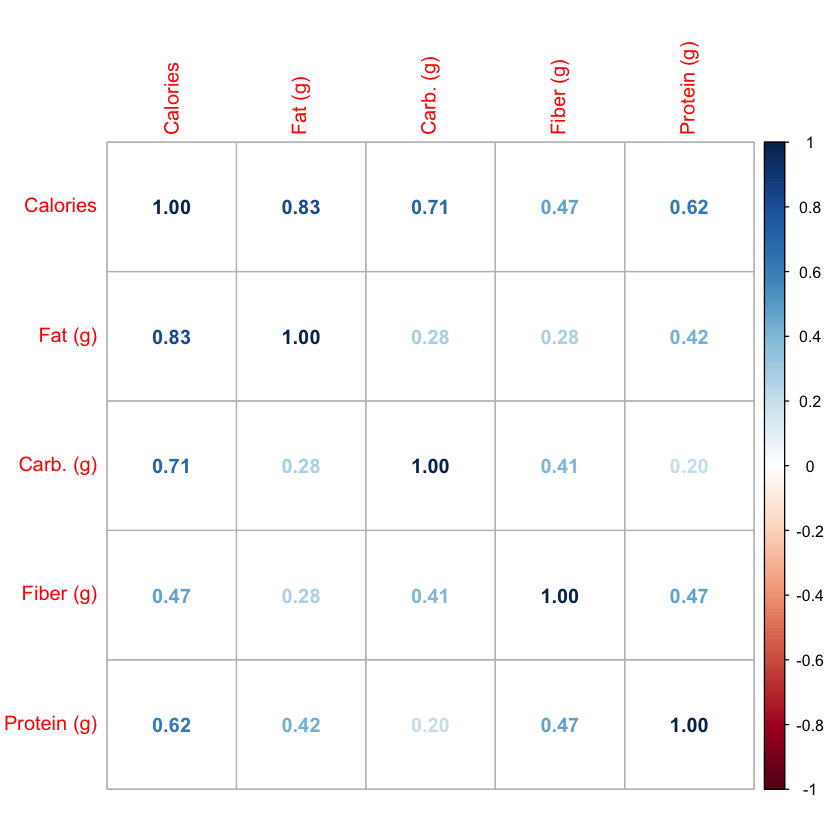

In [12]:
corrplot::corrplot(corrplot_input, method = "number")

There is a largre positive linear relationship between amount of Fat in and the amount of Calories in the products.

$$corr(\text{Fat, Calories})= 0.83$$

On the other hand, the correlation between amount of carbs and protein is, unsurprisingly, low. Lets check how these variables tohether look in a scatterplot:

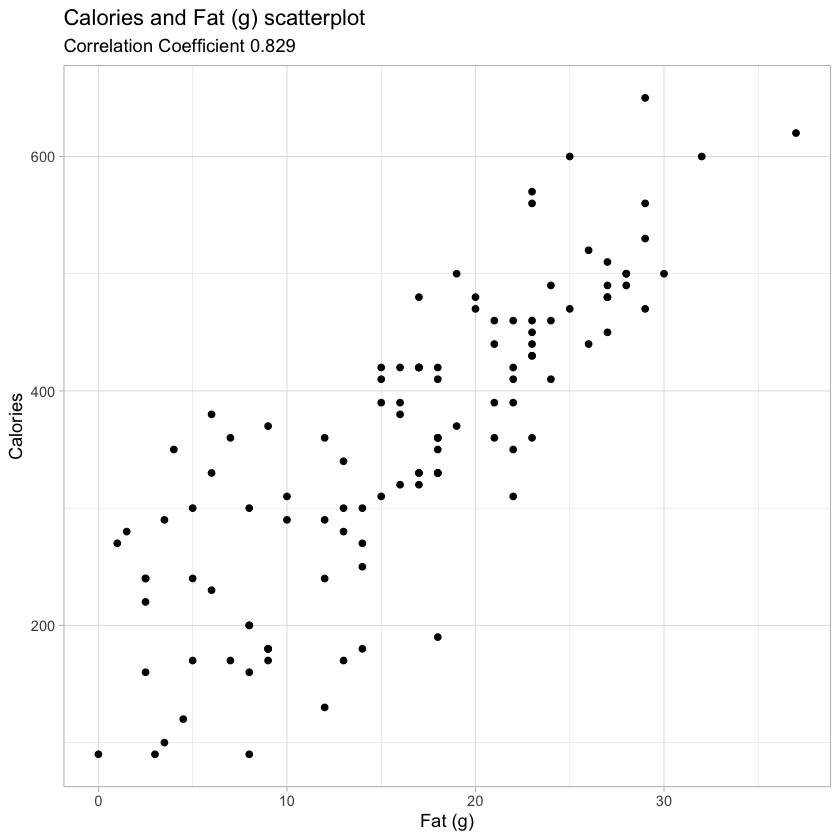

In [44]:
p1 <- data %>% 
    select(Calories, `Fat (g)`) %>% 
    ggplot() + 
    geom_point(aes(`Fat (g)`, Calories)) + 
    theme_light() + 
    labs(title = "Calories and Fat (g) scatterplot",
         subtitle = paste("Correlation Coefficient", round(cor(data$Calories, data$`Fat (g)`), 3)))

p1

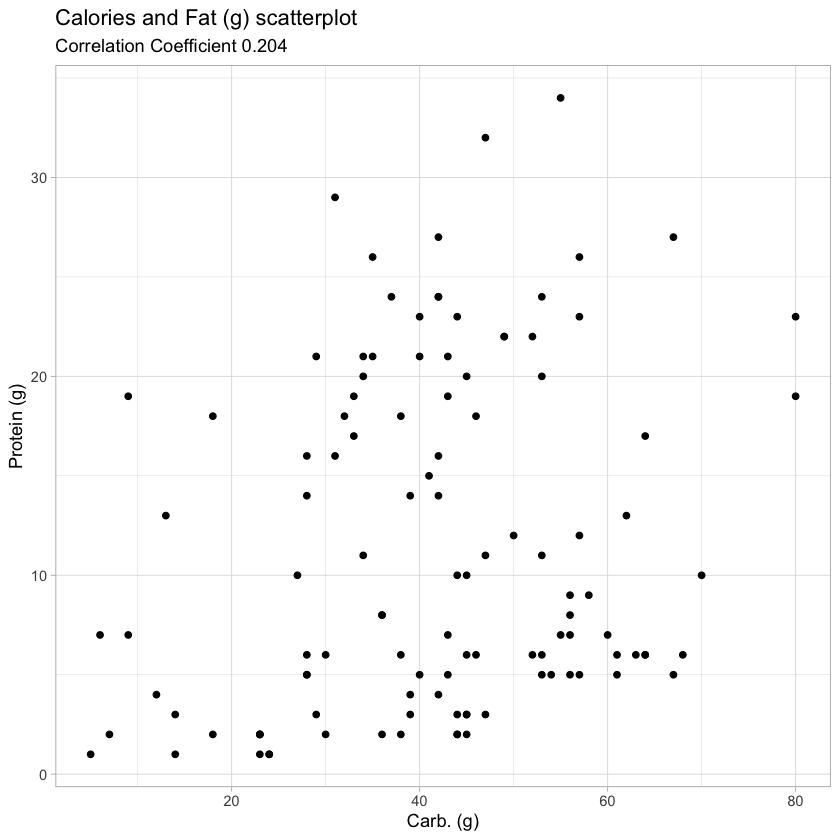

In [45]:
p2 <- data %>% 
    select(`Protein (g)`, `Carb. (g)`) %>% 
    ggplot() + 
    geom_point(aes(`Carb. (g)`, `Protein (g)`)) + 
    theme_light() + 
    labs(title = "Calories and Fat (g) scatterplot",
         subtitle = paste("Correlation Coefficient", round(cor(data$`Protein (g)`, data$`Carb. (g)`), 3)))

p2

We can use the `{patchwork}` package to combine the above plots and place them side-by-side.

```R
install.packages("patchwork")
```

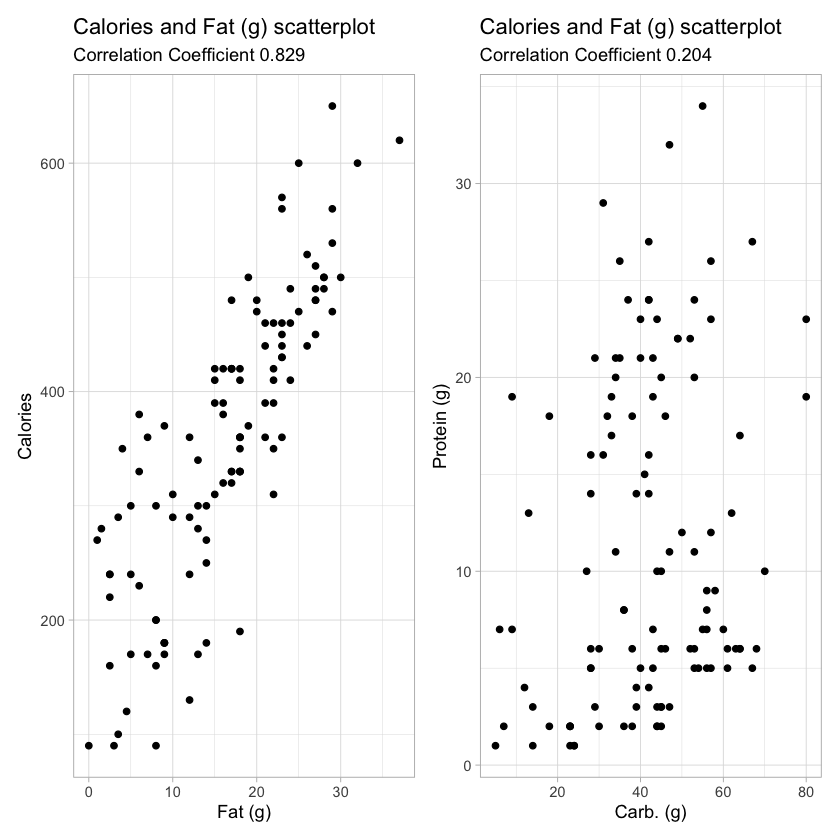

In [55]:
library(patchwork)

p1 + p2

In RStudio we can create an interactive scatterplot and adjust the amount of linear relationship between variable. To do so, install `{manipulate}` package:

```R
install.packages("manipulate")
```

First we need to create a function which will generate artificial data. This function will have parameter "theta" which will be the coefficient linearly connecting the first variable to the second to create some amount of positive correlation. Parameter N is the sample size.

```R
makeData <- function(theta, N){
  set.seed(123)
  X = rnorm(N, 2, 1)
  Y = theta*X + 2 + rnorm(N,0,1)
  return(tibble(X,Y))
}
``` 

Next, we load the manipulate package which allow's us to change value of function argument in the scatterplot to see how the datacloud changes. 

```R 
manipulate(plot(
  makeData(theta = th, 1000), # data input into plot() function
  main = paste(               # creating title with correlation coefficient using paste() and cor()
    "Correlation coefficient: ",
    round(cor(
      makeData(theta = th, 100)
    )[2])
  ),
  xlim = c(0, 8),             # range for x-axis
  ylim = c(0, 10)             # range for y-axis
),
th = slider(0.05, 2, 0.05)    # add slider for theta parameter from 0.02 to 2 with a step of 0.05    
)
```

The script will produce a scatter plot with a settings wheel located in the upper-left corner that includes a slider for the theta parameter. As the slider is adjusted, the plot will update automatically.

<div class="alert alert-block alert-info">
<b>Note:</b> {Manipulate} package works only in RStudio!
</div> 

# Logarithms and percentages:

The use of logarithms is closely connected to percentage representation. To see this, we will create a new variable simply called *Category* via `mutate()` function. This variable will contain a combination of variable *black* and *married*. The `case_when()` function allows us to encode the values based on the values of the original variables. Next we will group our data using `group_by()` based on the *category* and create means of wages for each category using `summarize()` function. 

In [152]:
temp <- data %>%
    mutate(category = case_when(black==1 & married == 1 ~ "black_married",
                                black==1 & married == 0 ~ "black_single",
                                black==0 & married == 1 ~ "non_black_married",
                                black==0 & married == 0 ~ "non_black_single"),
           category = factor(category)) %>%
    mutate(l_wage = log(wage)) %>%
    group_by(category) %>%
    summarize(mean_log_wage = mean(lwage))

temp

category,mean_log_wage
<fct>,<dbl>
black_married,6.554704
black_single,6.352906
non_black_married,6.835102
non_black_single,6.650079


the values in the second column correspond to these measures:

\begin{align}
\mathbb{E}\big[log(\text{wage})\; \vert \; \text{category} = \text{black_married}\big] = 6.55 \\
\mathbb{E}\big[log(\text{wage})\; \vert \; \text{category} = \text{black_single}\big] = 6.35 \\
\mathbb{E}\big[log(\text{wage})\; \vert \; \text{category} = \text{non_black_married}\big] = 6.84 \\
\mathbb{E}\big[log(\text{wage})\; \vert \; \text{category} = \text{non_black_single}\big] = 6.65 \\
\end{align}

The difference between the value is interpreted as *percentage difference*. Note that the difference is in geometric means!

In [149]:
6.835102 - 6.650079

[1] 0.185023

In [128]:
data %>%
    mutate(category = case_when(black==1 & married == 1 ~ "black_married",
                                black==1 & married == 0 ~ "black_single",
                                black==0 & married == 1 ~ "non_black_married",
                                black==0 & married == 0 ~ "non_black_single"),
        category = factor(category)) %>%
    mutate(l_wage = log(wage)) %>%
    group_by(category) %>%
    summarize(geometric_mean = exp(mean(lwage)),
             mean = mean(wage))

category,geometric_mean,mean
<fct>,<dbl>,<dbl>
black_married,702.5410,759.7941
black_single,574.1590,600.1111
non_black_married,929.9235,1007.2797
non_black_single,772.8453,841.9756


In [129]:
(929.9235 - 772.8453) / 772.8453 * 100

[1] 20.32466

In [130]:
(1007.2797 - 841.9756) / 841.9756 * 100

[1] 19.63288

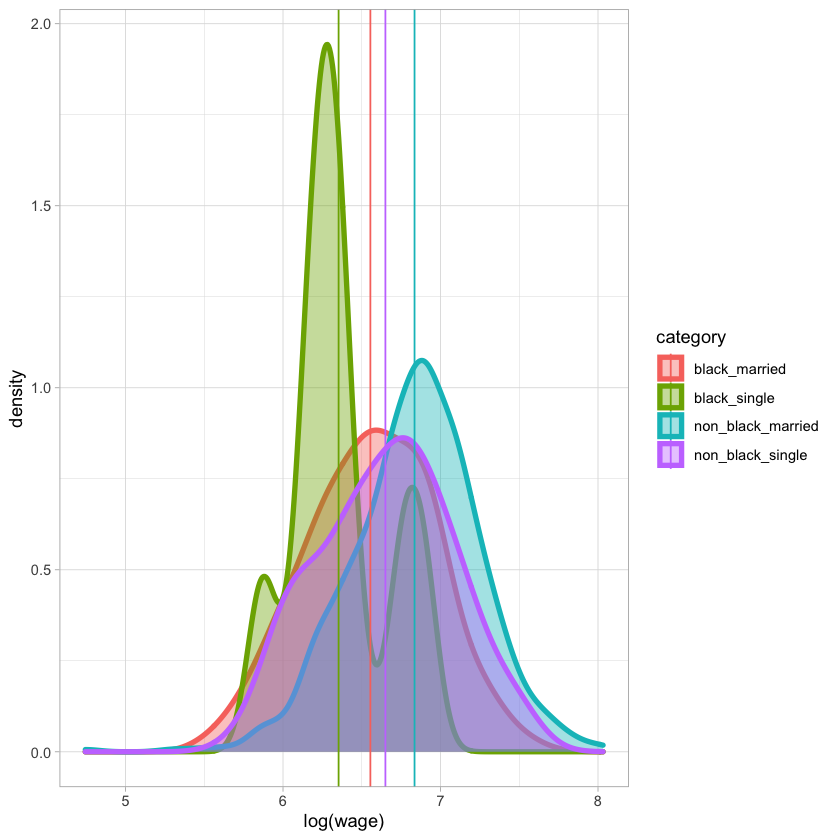

In [131]:
data %>%
    mutate(category = case_when(black==1 & married == 1 ~ "black_married",
                                black==1 & married == 0 ~ "black_single",
                                black==0 & married == 1 ~ "non_black_married",
                                black==0 & married == 0 ~ "non_black_single"),
        category = factor(category)) %>%
        group_by(category) %>%
        ggplot(aes(x = log(wage), fill=category, colour = category, group = category))+
        geom_density(lwd=1.5, alpha = 0.4)+
        geom_vline(data=temp, aes(xintercept = mean_log_wage, color = category))+
        theme_light()

In [ ]:
c